# Airy stress functions


Airy stress functions...

In [1]:
from __future__ import division
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 18
rcParams['axes.titlesize'] = 20

In [2]:
%matplotlib inline
x, y, z, t = symbols('x y z t')
f, g, h = symbols('f g h', cls=Function)
init_printing()

In [3]:
def poly_airy(x, y, order, coeff="c"):
    """Return a polynomial of a given order in x and y
    
    The coefficients of the polynomial are returned as a set in the
    variable ``c``.
    """
    num = (order**2 + 3*order + 2)/2
    c = symbols('%s0:%d' % (coeff, num))
    terms = [x**(order - k - j) * y**k for j in range(0, order - 1) for k in range(0, order + 1 - j)]
    phi = sum(c[k]*term for k, term in enumerate(terms))
    return phi, c


def airy_stress(phi, x, y):
    """Return stresses from the Airy stress function
    
    The coordinate system is Cartesian
    """
    return diff(phi, y, 2), diff(phi, x, 2), -diff(phi, y, 1, x, 1)

## Cantilever beam

In [4]:
a, b, F =  symbols("a b F")

In [5]:
phi, c = poly_airy(x, y, 4)

phi

In [6]:
s11, s22, s12 = airy_stress(phi, x, y)

In [7]:
t1 = s22.subs(y, b)
t2 = s12.subs(y, b)
t3 = s22.subs(y, -b)
t4 = s12.subs(y, -b)
t5 = s11.subs(x,0)
t6 = s12.subs(x,0)

In [8]:
eqlist = Poly(t1, x).coeffs() + Poly(t2, x).coeffs() + Poly(t3, x).coeffs() + Poly(t4, x).coeffs() 

In [9]:
eqlist.extend([integrate(t5, (y, -b, b)),
               integrate(t6, (y, -b, b)) - F,
               integrate(y*t5, (y, -b, b)),
               diff(phi, x, 4) + diff(phi, y, 4) + 2*diff(phi, x, 2, y, 2)])

In [10]:
sol = solve(eqlist, c)

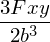

In [11]:
s11.subs(sol)

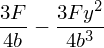

In [12]:
s12.subs(sol)

In [13]:
s22.subs(sol)

In [14]:
x_vec, y_vec = np.mgrid[0:10:100j, -1:1:100j]
s11_fun = lambdify((x, y, b, F), s11.subs(sol), "numpy")
s12_fun = lambdify((x, y, b, F), s12.subs(sol), "numpy")

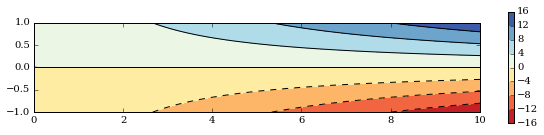

In [15]:
s11_vec = s11_fun(x_vec, y_vec, 1, 1)

plt.figure(figsize=(10, 2))
plt.contourf(x_vec, y_vec, s11_vec, cmap="RdYlBu")
plt.colorbar()
plt.contour(x_vec, y_vec, s11_vec, colors="k")
plt.axis("image")
plt.show()

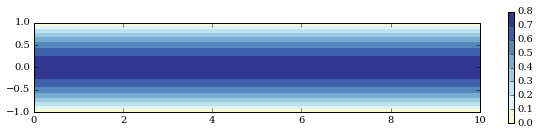

In [16]:
s12_vec = s12_fun(x_vec, y_vec, 1, 1)

plt.figure(figsize=(10, 2))
s12_min = np.min(s12_vec)
s12_max = np.max(s12_vec)
s12_max = max(s12_max, -s12_min)
plt.contourf(x_vec, y_vec, s12_vec, cmap="RdYlBu", vmin=-s12_max, vmax=s12_max)
plt.colorbar()
plt.axis("image")
plt.show()

## Beam under pure bending

In [17]:
L, b, S =  symbols("L b S")

In [18]:
phi, c = poly_airy(x, y, 3)

phi

In [19]:
s11, s22, s12 = airy_stress(phi, x, y)

In [20]:
conds = [s22.subs(y, b),
         s12.subs(y, b),
         s22.subs(y, -b),
         s12.subs(y, -b),
         s11.subs(x, L/2) - S*y,
         s12.subs(x, L/2),
         s11.subs(x, -L/2) - S*y,
         s12.subs(x, -L/2)]

conds

In [21]:
eqlist = [coef for cond in conds for coef in Poly(cond, (x, y)).coeffs()]

eqlist

In [22]:
sol = solve(eqlist, c)

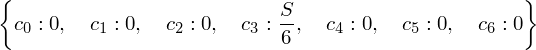

In [23]:
sol

In [24]:
s11.subs(sol)

In [25]:
s12.subs(sol)

In [26]:
s22.subs(sol)

In [27]:
s11_fun = lambdify((x, y, S), s11.subs(sol), "numpy")

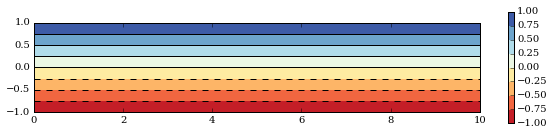

In [28]:
s11_vec = s11_fun(x_vec, y_vec, 1)

plt.figure(figsize=(10, 2))
plt.contourf(x_vec, y_vec, s11_vec, cmap="RdYlBu")
plt.colorbar()
plt.contour(x_vec, y_vec, s11_vec, colors="k")
plt.axis("image")
plt.show()

## Simply supported beam with uniform force

In [29]:
L, b, S, F =  symbols("L b S F")

In [45]:
phi, d = poly_airy(x, y, 5)

phi

In [46]:
s11, s22, s12 = airy_stress(phi, x, y)

In [47]:
conds = [s22.subs(y, b) + S,
         s12.subs(y, b),
         s22.subs(y, -b),
         s12.subs(y, -b),
         integrate(s11.subs(x, L), (y,-b, b)),
         integrate(s12.subs(x, L), (y,-b, b)) - F,
         integrate(y*s11.subs(x, L), (y,-b, b)),
         integrate(s11.subs(x, -L), (y,-b, b)),
         integrate(s12.subs(x, -L), (y,-b, b)) - F,
         integrate(y*s11.subs(x, -L), (y,-b, b)),
         diff(phi, x, 4) + diff(phi, y, 4) + 2*diff(phi, x, 2, y, 2)]

conds

In [48]:
eqlist = set(coef for cond in conds for coef in Poly(cond, (x, y)).coeffs())

eqlist

In [49]:
sol = solve(eqlist, d)

In [50]:
sol

In [37]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()